# Assignment 6: Neural Network Showdown

Build and compare neural network architectures on image and time-series data.

## Setup

In [1]:
%pip install -q -r requirements.txt

# GPU acceleration (platform-specific)
import platform
if platform.system() == "Darwin" and platform.machine() == "arm64":
    %pip install -q tensorflow-metal

%reset -f

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
%matplotlib inline
import matplotlib 
import os
import json
import numpy as np
import pandas as pd

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf
tf.random.set_seed(42)
np.random.seed(42)

# Report available accelerators
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPU acceleration: {len(gpus)} device(s)")
    for gpu in gpus:
        print(f"  {gpu.name}")
else:
    print("No GPU detected — using CPU")

from tensorflow import keras
from keras import Sequential
from keras.layers import (
    Dense, Flatten, Dropout, Conv2D, MaxPooling2D, LSTM, Input
)
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix

from helpers import (
    load_cifar10, load_ecg5000,
    plot_training_history, plot_confusion_matrix,
    plot_sample_images, plot_ecg_traces, plot_predictions,
    CIFAR10_CLASSES, ECG_CLASSES,
)

OUTPUT_DIR = "output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Setup complete!")

No GPU detected — using CPU
Setup complete!


---

## Part 1: Dense Baseline on CIFAR-10

**Task:** Build a Dense (fully connected) network to classify CIFAR-10 images.

CIFAR-10 has 60,000 color images (32x32x3) across 10 classes. A Dense network
flattens each image into 3,072 numbers and classifies from there. This is our
baseline — it ignores spatial structure entirely.

**Architecture requirements:**
- Flatten the input
- At least 2 hidden Dense layers with ReLU activation
- Dropout after each hidden layer
- Output: Dense(10, softmax)

In [6]:

print("Part 1: Dense Baseline on CIFAR-10")
print("-" * 40)

# Load data (normalized to [0,1], one-hot encoded)
X_train, y_train, X_test, y_test = load_cifar10()
print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Part 1: Dense Baseline on CIFAR-10
----------------------------------------
Train: (50000, 32, 32, 3), Test: (10000, 32, 32, 3)


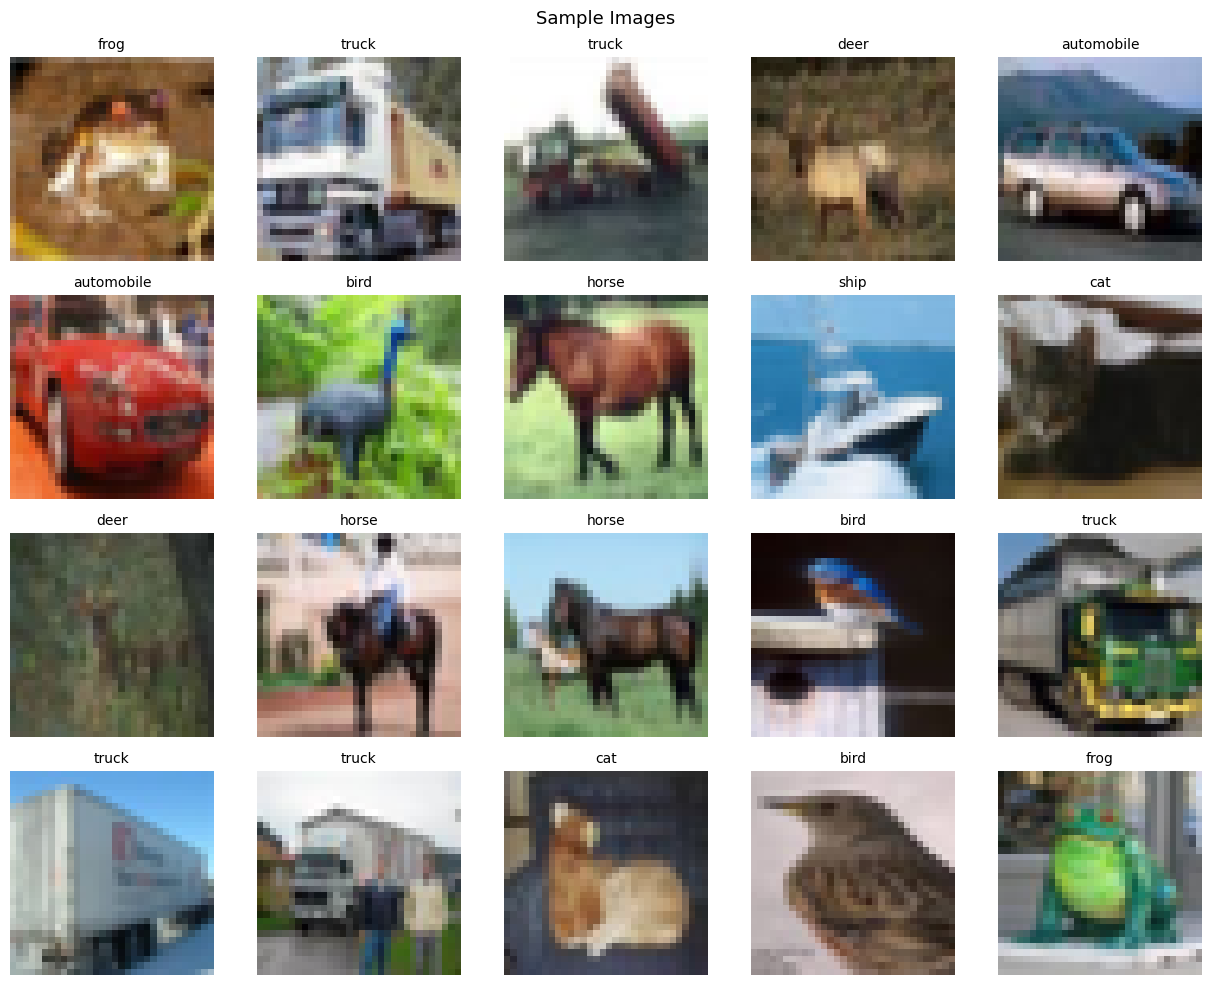

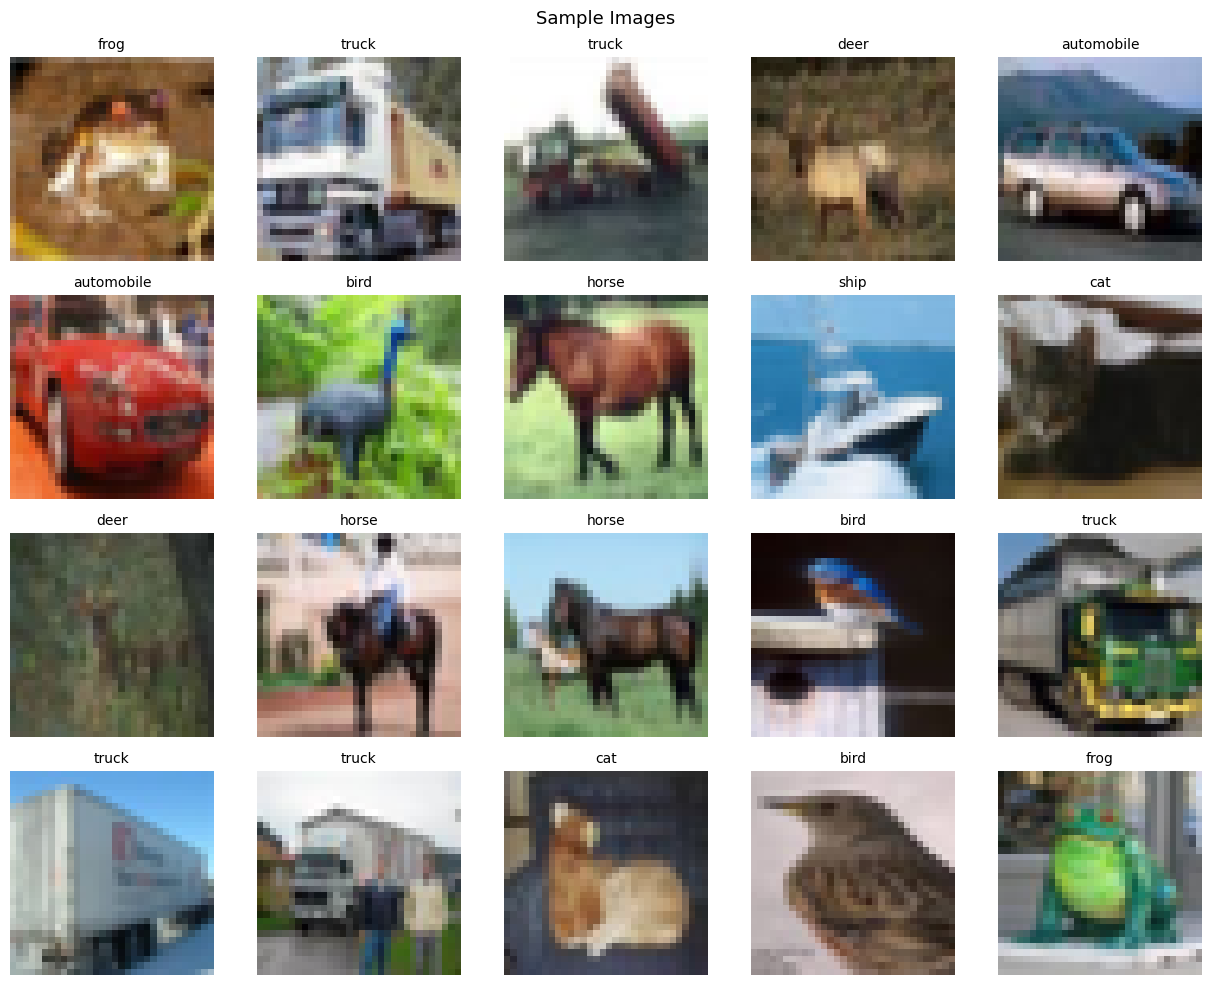

In [7]:
# Visualize some training images to verify data loaded correctly
plot_sample_images(X_train, y_train, CIFAR10_CLASSES)


In [8]:
# TODO: Build a Dense model using Sequential
# Tip: call model_dense.summary() after building to verify your architecture
# Requirements:
#   - Input(shape=(32, 32, 3))
#   - Flatten()
#   - At least 2 Dense hidden layers with activation='relu'
#   - Dropout after each hidden Dense layer
#   - Dense(10, activation='softmax') as output
model_dense = Sequential([
    Flatten(input_shape = (32,32,3)),
    Dense(256,activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64,activation='relu'),
    Dense(10, activation='softmax')

])  # replace with your Sequential model
model_dense.summary

<bound method Model.summary of <keras.src.engine.sequential.Sequential object at 0x16c2f5bd0>>

In [9]:
# TODO: Compile the model
model_dense.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

In [10]:
# TODO: Train with EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3,
                           restore_best_weights=True)
history_dense = model_dense.fit(X_train, y_train,
                                epochs=20, batch_size=128,
                                validation_split=0.1,
                                callbacks=[early_stop])


Epoch 1/20
352/352 [==============================] - 1s 4ms/step - loss: 2.0715 - accuracy: 0.2251 - val_loss: 1.9175 - val_accuracy: 0.2942
Epoch 2/20
352/352 [==============================] - 1s 3ms/step - loss: 1.9363 - accuracy: 0.2822 - val_loss: 1.8681 - val_accuracy: 0.3240
Epoch 3/20
352/352 [==============================] - 1s 3ms/step - loss: 1.8853 - accuracy: 0.3046 - val_loss: 1.8049 - val_accuracy: 0.3490
Epoch 4/20
352/352 [==============================] - 1s 3ms/step - loss: 1.8550 - accuracy: 0.3149 - val_loss: 1.7861 - val_accuracy: 0.3610
Epoch 5/20
352/352 [==============================] - 1s 3ms/step - loss: 1.8345 - accuracy: 0.3240 - val_loss: 1.7631 - val_accuracy: 0.3660
Epoch 6/20
352/352 [==============================] - 1s 3ms/step - loss: 1.8232 - accuracy: 0.3287 - val_loss: 1.7561 - val_accuracy: 0.3758
Epoch 7/20
352/352 [==============================] - 1s 3ms/step - loss: 1.8010 - accuracy: 0.3398 - val_loss: 1.7384 - val_accuracy: 0.3778
Epoch 

In [11]:
# TODO: Evaluate on test set
test_loss, test_acc = model_dense.evaluate(X_test, y_test, verbose=0)
# TODO: Generate predictions and confusion matrix
y_pred = np.argmax(model_dense.predict(X_test, verbose=0), axis=1)
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_pred)

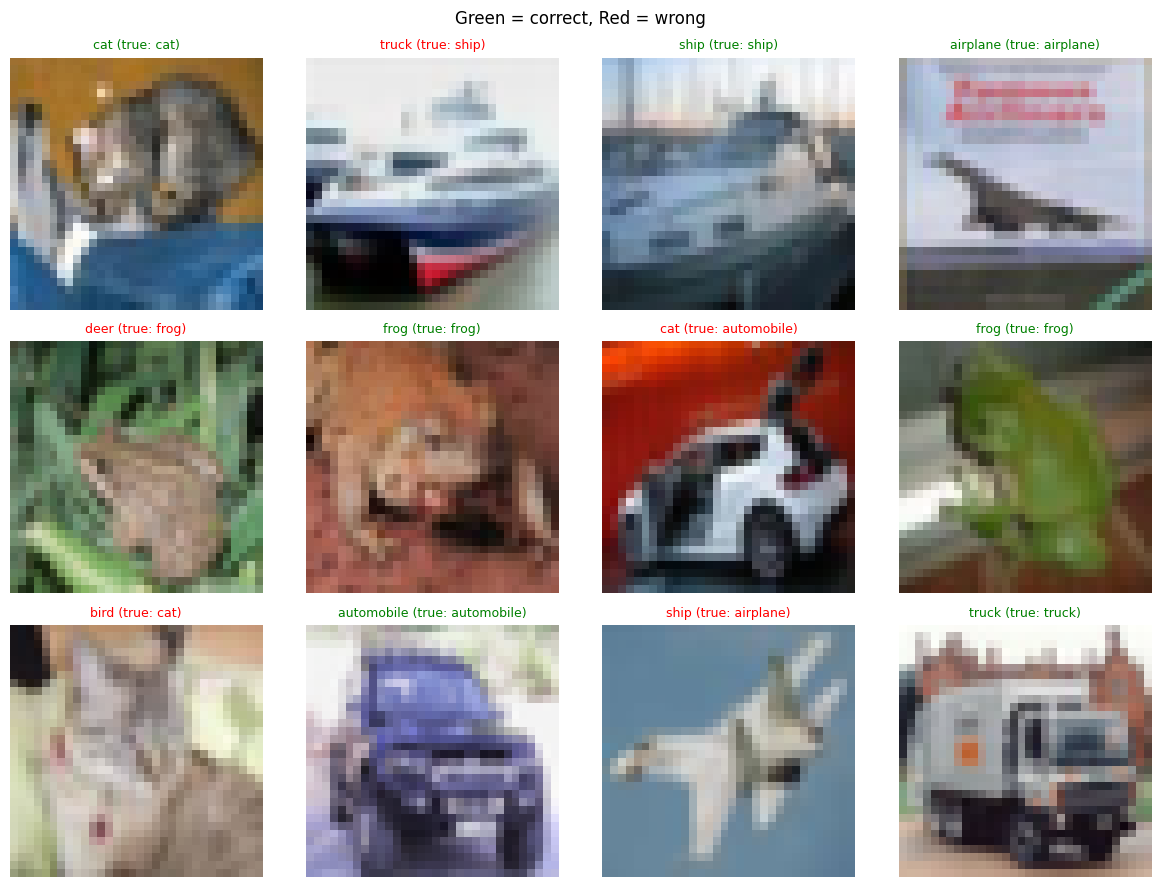

In [12]:
# Optional: visualize predictions and confusion matrix to diagnose issues
plot_predictions(X_test, y_true, y_pred, CIFAR10_CLASSES)
plot_confusion_matrix(y_true, y_pred, list(CIFAR10_CLASSES.values()),
                      os.path.join(OUTPUT_DIR, "part1_confusion_matrix.png"))

In [ ]:
# Save results (do not modify this cell)
results = {
    "accuracy": float(test_acc),
    "confusion_matrix": cm.tolist(),
}
with open(os.path.join(OUTPUT_DIR, "part1_results.json"), "w") as f:
    json.dump(results, f, indent=2)

print(f"Dense accuracy: {test_acc:.4f}")
print("Saved output/part1_results.json")

---

## Part 2: CNN on CIFAR-10

**Task:** Build a CNN to classify the same CIFAR-10 images. Compare its accuracy
to the Dense baseline from Part 1.

CNNs use convolutional filters that slide across the image, detecting local
patterns (edges, textures, shapes). This preserves spatial structure that
Dense layers discard.

**Architecture requirements:**
- At least 2 Conv2D + MaxPooling2D blocks
- Flatten, then Dense hidden layer with Dropout
- Output: Dense(10, softmax)

In [13]:
print("\nPart 2: CNN on CIFAR-10")
print("-" * 40)

# Data is already loaded from Part 1 (X_train, y_train, X_test, y_test)


Part 2: CNN on CIFAR-10
----------------------------------------


In [14]:
# TODO: Build a CNN model using Sequential
# Requirements:
#   - Input(shape=(32, 32, 3))
#   - At least 2 blocks of: Conv2D(filters, (3,3), activation='relu')
#                            + MaxPooling2D((2,2))
#   - Flatten()
#   - Dense hidden layer with ReLU + Dropout
#   - Dense(10, activation='softmax') as output
# Tip: call model_cnn.summary() after building to check layer shapes and param counts
model_cnn = Sequential([
    Conv2D(32,(3,3),activation='relu', input_shape = (32,32,3)),
    MaxPooling2D((2,2)),
    Conv2D(64,(3,3),activation='relu'),MaxPooling2D((2,2)),
    Flatten(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')])  # replace with your Sequential model
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 2304)              0         
                                                                 
 dropout_2 (Dropout)         (None, 2304)             

In [15]:
# TODO: Compile the model
model_cnn.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [20]:
# TODO: Train with EarlyStopping and ModelCheckpoint
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3,
                  restore_best_weights=True),
    ModelCheckpoint('output/best_cnn.h5',
                    save_best_only=True, 
                    monitor='val_accuracy'),
]
history_cnn = model_cnn.fit(X_train, y_train,
                            epochs=15, batch_size=64,
                            validation_split=0.1,
                            callbacks=callbacks)

Epoch 1/15
704/704 [==============================] - 9s 13ms/step - loss: 1.1085 - accuracy: 0.6117 - val_loss: 1.0013 - val_accuracy: 0.6536
Epoch 2/15
 11/704 [..............................] - ETA: 7s - loss: 1.0977 - accuracy: 0.6236

/Users/tara/miniconda3/envs/brainiac/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


704/704 [==============================] - 8s 12ms/step - loss: 1.0513 - accuracy: 0.6327 - val_loss: 0.9619 - val_accuracy: 0.6740
Epoch 3/15
704/704 [==============================] - 8s 12ms/step - loss: 1.0057 - accuracy: 0.6470 - val_loss: 0.9328 - val_accuracy: 0.6824
Epoch 4/15
704/704 [==============================] - 8s 11ms/step - loss: 0.9699 - accuracy: 0.6606 - val_loss: 0.9264 - val_accuracy: 0.6886
Epoch 5/15
704/704 [==============================] - 8s 11ms/step - loss: 0.9320 - accuracy: 0.6737 - val_loss: 0.8606 - val_accuracy: 0.7032
Epoch 6/15
704/704 [==============================] - 8s 11ms/step - loss: 0.9073 - accuracy: 0.6823 - val_loss: 0.8431 - val_accuracy: 0.7146
Epoch 7/15
704/704 [==============================] - 8s 12ms/step - loss: 0.8757 - accuracy: 0.6923 - val_loss: 0.8259 - val_accuracy: 0.7150
Epoch 8/15
704/704 [==============================] - 8s 11ms/step - loss: 0.8552 - accuracy: 0.7007 - val_loss: 0.8151 - val_accuracy: 0.7228
Epoch 9/15

In [21]:
# TODO: Plot training history
plot_training_history(history_cnn,
                      os.path.join(OUTPUT_DIR, "part2_training_history.png"))

In [22]:
# TODO: Evaluate on test set
cnn_loss, cnn_acc = model_cnn.evaluate(X_test, y_test, verbose=0)
# TODO: Generate predictions and confusion matrix
y_pred_cnn = np.argmax(model_cnn.predict(X_test, verbose=0), axis=1)
y_true_cnn = np.argmax(y_test, axis=1)
cm_cnn = confusion_matrix(y_true_cnn, y_pred_cnn)

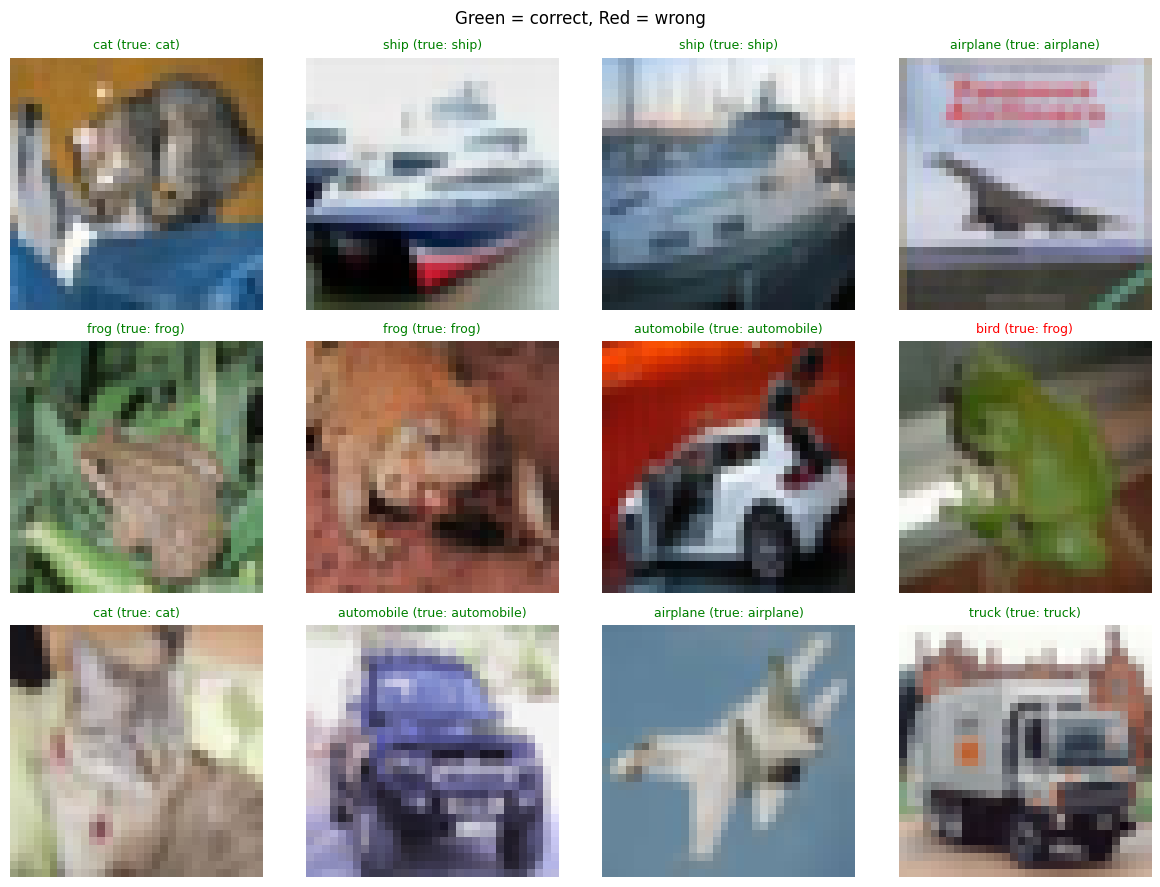

In [23]:
# Optional: visualize predictions and confusion matrix to diagnose issues
plot_predictions(X_test, y_true_cnn, y_pred_cnn, CIFAR10_CLASSES)
plot_confusion_matrix(y_true_cnn, y_pred_cnn, list(CIFAR10_CLASSES.values()),
                      os.path.join(OUTPUT_DIR, "part2_confusion_matrix.png"))

In [24]:
# Save results (do not modify this cell)
results_cnn = {
    "accuracy": float(cnn_acc),
    "confusion_matrix": cm_cnn.tolist(),
}
with open(os.path.join(OUTPUT_DIR, "part2_results.json"), "w") as f:
    json.dump(results_cnn, f, indent=2)

comparison = pd.DataFrame([
    {"model": "Dense", "accuracy": float(test_acc)},
    {"model": "CNN", "accuracy": float(cnn_acc)},
])
comparison.to_csv(os.path.join(OUTPUT_DIR, "part2_comparison.csv"), index=False)

print(f"CNN accuracy:   {cnn_acc:.4f}")
print(f"Dense accuracy: {test_acc:.4f}")
print(f"Improvement:    {cnn_acc - test_acc:+.4f}")
print("Saved output/part2_results.json and output/part2_comparison.csv")

CNN accuracy:   0.7193
Dense accuracy: 0.4107
Improvement:    +0.3086
Saved output/part2_results.json and output/part2_comparison.csv


---

## Part 3: LSTM on ECG5000

**Task:** Build an LSTM to classify heartbeat recordings.

ECG5000 contains 5,000 heartbeat recordings — each is 140 time steps of voltage
measurements, classified into 5 types (Normal, Supraventricular, Premature
Ventricular, Fusion, Unknown). This is sequential data where order matters,
making it a natural fit for recurrent networks.

**Architecture requirements:**
- LSTM layer (any reasonable number of units)
- Dropout for regularization
- Dense output with softmax (5 classes)

In [25]:
print("\nPart 3: LSTM on ECG5000")
print("-" * 40)

# Load ECG data (already shaped for RNN input)
X_train_ecg, y_train_ecg, X_test_ecg, y_test_ecg = load_ecg5000()
print(f"Train: {X_train_ecg.shape}, Test: {X_test_ecg.shape}")
print(f"Classes: {list(ECG_CLASSES.values())}")


Part 3: LSTM on ECG5000
----------------------------------------
Train: (4000, 140, 1), Test: (1000, 140, 1)
Classes: ['Normal', 'Supraventricular', 'Premature Ventricular', 'Fusion', 'Unknown']


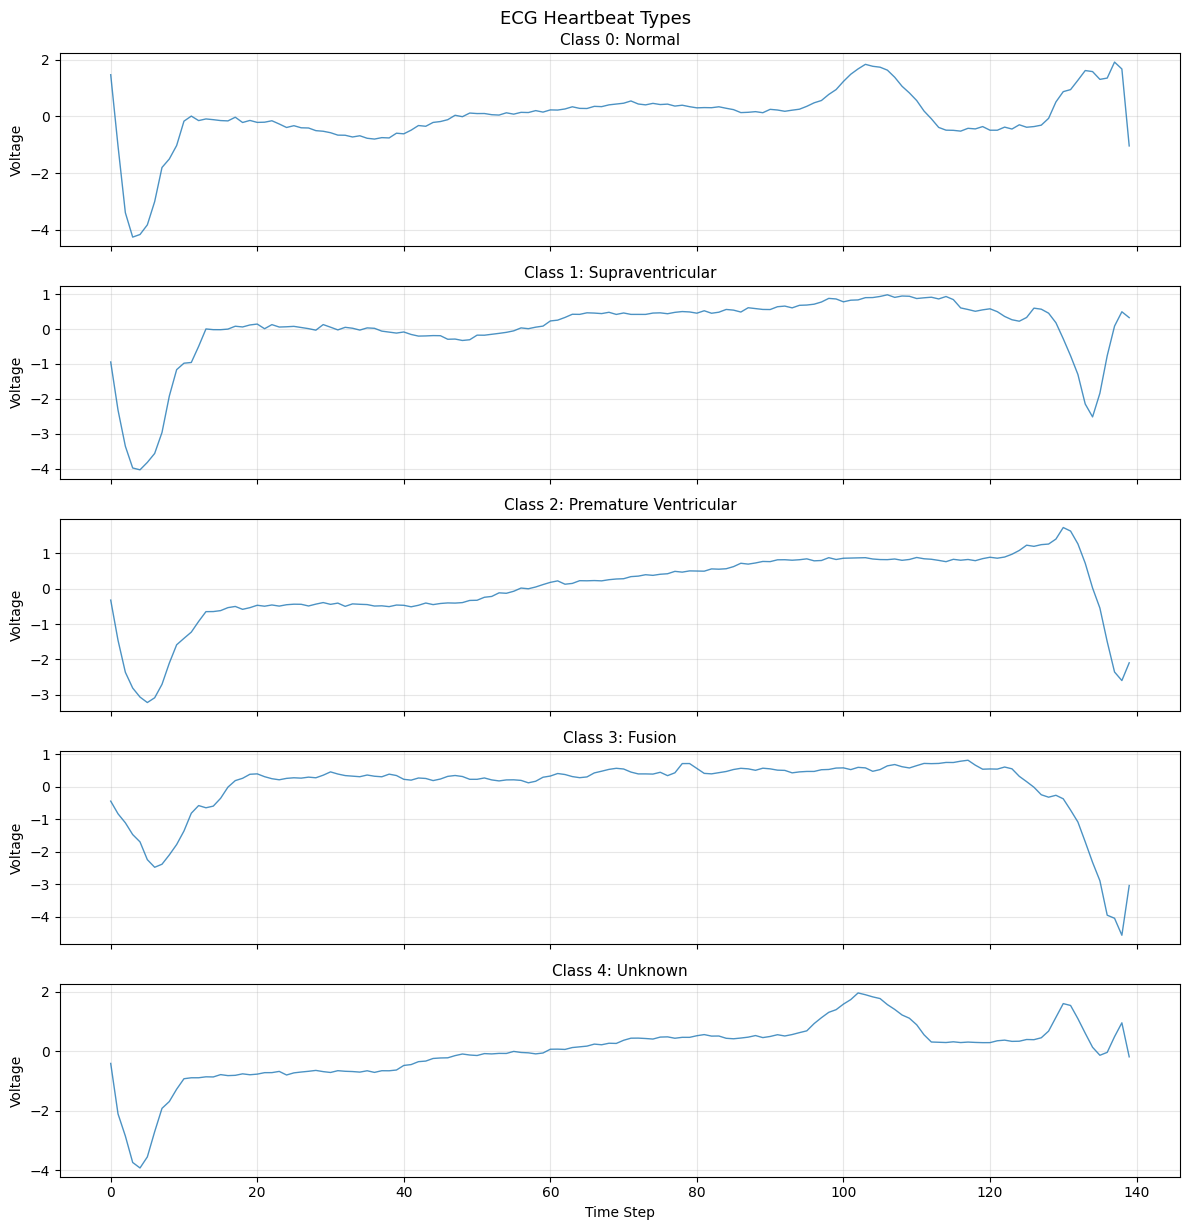

In [26]:
# Visualize ECG traces to understand the data
plot_ecg_traces(X_train_ecg, y_train_ecg, ECG_CLASSES)

In [27]:
# TODO: Build an LSTM model using Sequential
# Requirements:
#   - Input(shape=(140, 1))
#   - LSTM layer (e.g., 64 units)
#   - Dropout
#   - Dense(5, activation='softmax')
# Tip: call model_lstm.summary() after building to verify your architecture
model_lstm = Sequential([
    LSTM(64, input_shape=(140, 1)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(5, activation='softmax')  # 5 heartbeat classes
])  # replace with your Sequential model
model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 5)                 165       
                                                                 
Total params: 19141 (74.77 KB)
Trainable params: 19141 (74.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [28]:
# TODO: Compile the model
model_lstm.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

In [29]:
# TODO: Train with EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5,
                           restore_best_weights=True)
history_lstm = model_lstm.fit(X_train_ecg, y_train_ecg,
                              epochs=30, batch_size=32,
                              validation_split=0.1,
                              callbacks=[early_stop])


Epoch 1/30
113/113 [==============================] - 3s 20ms/step - loss: 0.5491 - accuracy: 0.8856 - val_loss: 0.3588 - val_accuracy: 0.8925
Epoch 2/30
113/113 [==============================] - 2s 18ms/step - loss: 0.2758 - accuracy: 0.9264 - val_loss: 0.3585 - val_accuracy: 0.8925
Epoch 3/30
113/113 [==============================] - 2s 18ms/step - loss: 0.2675 - accuracy: 0.9275 - val_loss: 0.3306 - val_accuracy: 0.8975
Epoch 4/30
113/113 [==============================] - 2s 17ms/step - loss: 0.2370 - accuracy: 0.9375 - val_loss: 0.3083 - val_accuracy: 0.9150
Epoch 5/30
113/113 [==============================] - 2s 17ms/step - loss: 0.2170 - accuracy: 0.9417 - val_loss: 0.2943 - val_accuracy: 0.9225
Epoch 6/30
113/113 [==============================] - 2s 18ms/step - loss: 0.2090 - accuracy: 0.9425 - val_loss: 0.2910 - val_accuracy: 0.9225
Epoch 7/30
113/113 [==============================] - 2s 17ms/step - loss: 0.2021 - accuracy: 0.9442 - val_loss: 0.2747 - val_accuracy: 0.9225

In [30]:
# TODO: Plot training history
plot_training_history(history_lstm,
                      os.path.join(OUTPUT_DIR, "part3_training_history.png"))

In [31]:
# TODO: Evaluate on test set
lstm_loss, lstm_acc = model_lstm.evaluate(X_test_ecg, y_test_ecg, verbose=0)

# TODO: Generate predictions and confusion matrix
y_pred_ecg = np.argmax(model_lstm.predict(X_test_ecg, verbose=0), axis=1)
y_true_ecg = np.argmax(y_test_ecg, axis=1)
cm_ecg = confusion_matrix(y_true_ecg, y_pred_ecg)


In [32]:
# Optional: visualize confusion matrix to see which heartbeat types are confused
plot_confusion_matrix(y_true_ecg, y_pred_ecg, list(ECG_CLASSES.values()),
                      os.path.join(OUTPUT_DIR, "part3_confusion_matrix.png"))

In [33]:
# Save results (do not modify this cell)
results_ecg = {
    "accuracy": float(lstm_acc),
    "confusion_matrix": cm_ecg.tolist(),
}
with open(os.path.join(OUTPUT_DIR, "part3_results.json"), "w") as f:
    json.dump(results_ecg, f, indent=2)

print(f"LSTM accuracy: {lstm_acc:.4f}")
print("Saved output/part3_results.json")

LSTM accuracy: 0.9340
Saved output/part3_results.json


---

## Validation

In [34]:
print("\nAll parts complete!")
print("Run 'pytest .github/tests/ -v' in your terminal to check your work.")


All parts complete!
Run 'pytest .github/tests/ -v' in your terminal to check your work.
